In [1]:
!pwd

/Users/ashish1610dhiman/gatech_projects/time_series_practice/notebooks/stocks_clustering


In [2]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

from sklearn.metrics import adjusted_mutual_info_score as ami

from tqdm.notebook import tqdm

sys.version

/Users/ashish1610dhiman/opt/anaconda3/envs/time_series_practice/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


'3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:55:37) \n[Clang 14.0.6 ]'

In [3]:
%load_ext autoreload 
%autoreload 2

In [4]:
SEED = 77

### Preprocess data

In [5]:
df_ticker = pd.read_csv("../../data/sp500_ticker_sector.csv")
stock_prices = pd.read_csv("../../data/sp500_stock_prices.xlsx", header=[0, 1], low_memory=False)

In [6]:
stock_prices.head()

Date  Adj Close                                               \
  Unnamed: 0_level_1          A        AAL         AAP       AAPL       ABBV   
0         2015-01-02  37.941978  51.079910  148.292755  24.603207  46.979839   
1         2015-01-05  37.231033  51.051483  146.338089  23.910097  46.095711   
2         2015-01-06  36.651051  50.255592  146.235245  23.912344  45.867554   
3         2015-01-07  37.137489  50.227158  149.377655  24.247646  47.721359   
4         2015-01-08  38.250690  50.843033  150.686996  25.179295  48.220463   

                                               ...   Volume           \
         ABC        ABT       ACGL        ACN  ...     WYNN      XEL   
0  79.608658  38.606461  19.496668  77.739204  ...  2228900  2534900   
1  78.931030  38.615059  19.379999  76.426620  ...  1695100  3107200   
2  79.362244  38.176548  19.423332  75.875359  ...  1975800  4749600   
3  80.946335  38.486088  19.536667  77.467957  ...  1472000  2833400   
4  81.131142  39.277130  19.876667  78.649269  ...  1676600  2516800   

                                                                           
        XOM     XRAY      XYL      YUM      ZBH    ZBRA     ZION      ZTS  
0  10220400  1825800   605900  2283466   936579  411800  2298700  1784200  
1  18502400  1469800  1369900  4418651  2223873  420300  5326000  3112100  
2  16670700  1988400  1333200  5004401  1835563  527500  9086500  3977200  
3  13590700   959800  1038600  4554134  1505860  467800  2759900  2481800  
4  15487500  1409500   821800  4258268  1449004  324400  1831500  3121300  

[5 rows x 3019 columns]

In [7]:
stock_prices.columns.get_level_values(0).unique()

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [8]:
close_prices = stock_prices["Adj Close"]
close_prices.index = pd.to_datetime(stock_prices[(     'Date', 'Unnamed: 0_level_1')].values)

close_prices.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2015-01-02,37.941978,51.079910,148.292755,24.603207,46.979839,79.608658,38.606461,19.496668,77.739204,72.339996,...,129.636993,28.517212,64.210571,48.983879,34.356831,44.717999,102.588860,77.430000,24.001354,41.048908
2015-01-05,37.231033,51.051483,146.338089,23.910097,46.095711,78.931030,38.615059,19.379999,76.426620,71.980003,...,127.430618,28.193502,62.453659,48.644310,32.218552,43.809429,106.415825,76.339996,23.102049,40.802483
2015-01-06,36.651051,50.255592,146.235245,23.912344,45.867554,79.362244,38.176548,19.423332,75.875359,70.529999,...,124.712395,28.343513,62.121616,48.040611,32.029087,43.271706,105.513763,75.790001,22.219706,40.404411
2015-01-07,37.137489,50.227158,149.377655,24.247646,47.721359,80.946335,38.486088,19.536667,77.467957,71.110001,...,128.374954,28.588259,62.751083,49.285732,32.281708,44.705647,108.137901,77.720001,22.431808,41.238476
2015-01-08,38.250690,50.843033,150.686996,25.179295,48.220463,81.131142,39.277130,19.876667,78.649269,72.919998,...,129.919403,28.919870,63.795555,50.502537,32.525307,45.484417,109.286026,79.379997,22.745718,41.873493


In [9]:
close_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1815 entries, 2015-01-02 to 2022-03-17
Columns: 503 entries, A to ZTS
dtypes: float64(503)
memory usage: 7.0 MB


In [10]:
close_prices.shape, close_prices.dropna(axis=1).shape, close_prices.dropna(axis=1).isna().sum().sum()

((1815, 503), (1815, 479), 0)

In [11]:
close_prices = close_prices.dropna(axis=1)
close_prices.shape

(1815, 479)

In [12]:
close_prices.index = pd.to_datetime(close_prices.index)

In [13]:
close_prices = close_prices["2018":]
close_prices.shape

(1060, 479)

In [14]:
close_prices.to_csv("../../data/sp500_close_prices.csv")

#### Sample plots

<AxesSubplot: >

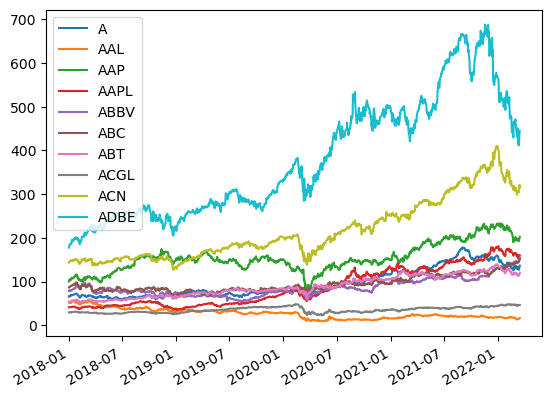

In [15]:
close_prices[list(close_prices.columns)[:10]].plot()

<AxesSubplot: >

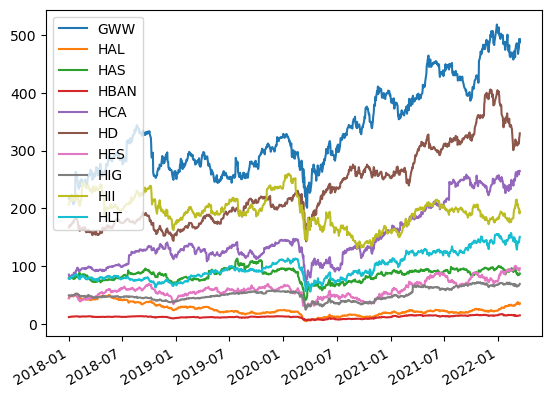

In [16]:
close_prices[list(close_prices.columns)[200:210]].plot()

#### Sectors available

In [17]:
df_ticker.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [18]:
df_ticker["GICS Sector"].value_counts(),df_ticker["GICS Sector"].nunique()

(Information Technology    76
 Industrials               70
 Financials                67
 Health Care               63
 Consumer Discretionary    56
 Consumer Staples          33
 Real Estate               31
 Utilities                 30
 Materials                 29
 Communication Services    25
 Energy                    23
 Name: GICS Sector, dtype: int64,
 11)

### Time Series Clustering
#### Preprocess time series data

In [19]:
close_prices.shape

(1060, 479)

In [20]:
#we have 479 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(close_prices.T)
X_train.shape

(479, 1060, 1)

In [21]:
get_sector = lambda x: df_ticker[df_ticker.Symbol==x]["GICS Sector"].values[0]

In [22]:
get_sector("MMM")

'Industrials'

In [23]:
y_train = np.array([get_sector(tick) for tick in close_prices.columns])
y_train.shape

(479,)

<AxesSubplot: >

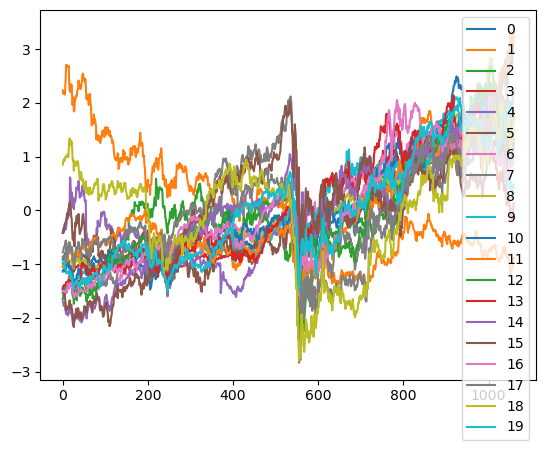

In [24]:
pd.DataFrame(X_train[:20,:,0].T).plot()

#### Plot all sectors together

In [25]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 5]

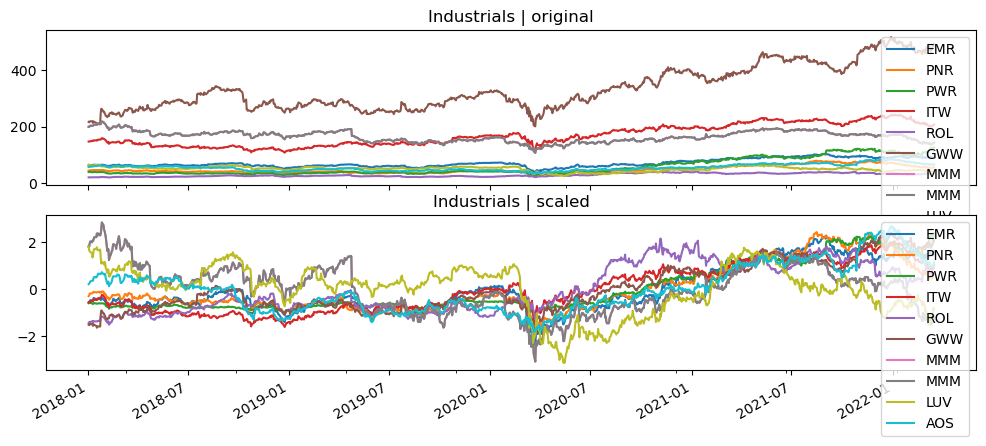

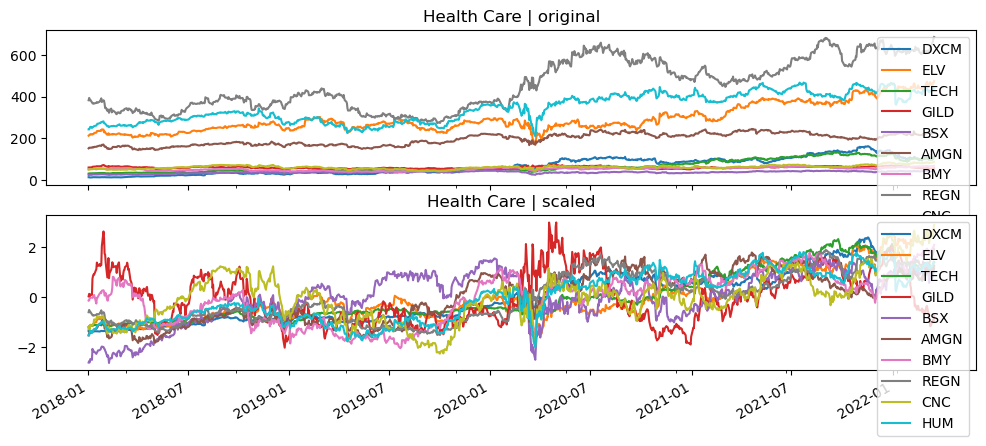

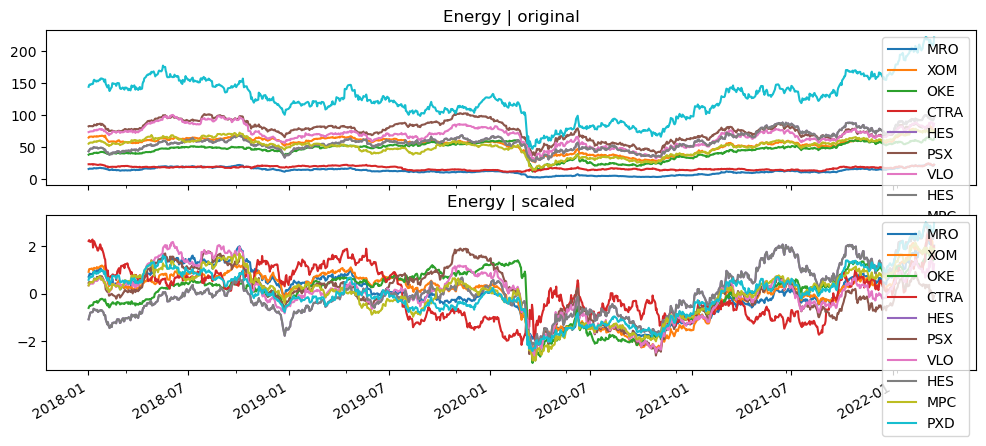

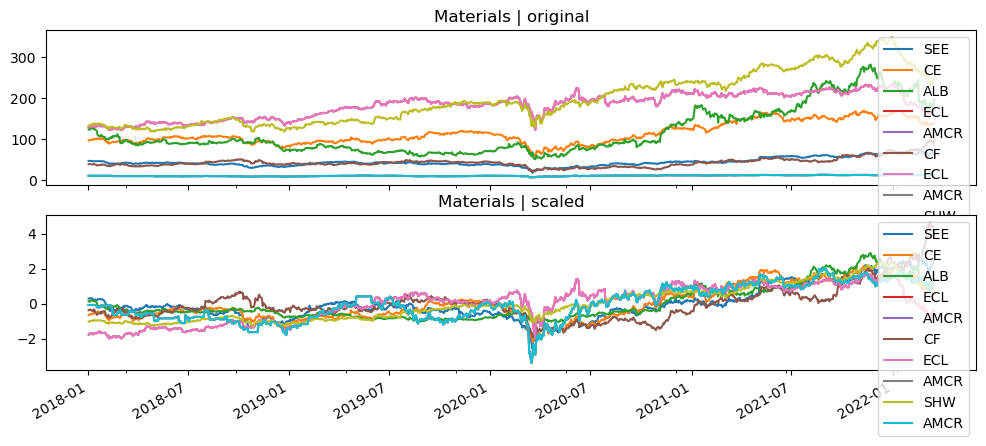

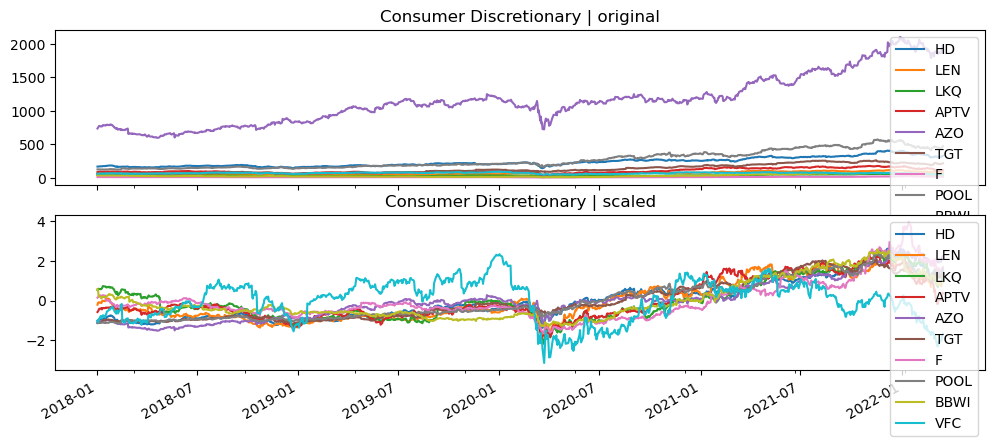

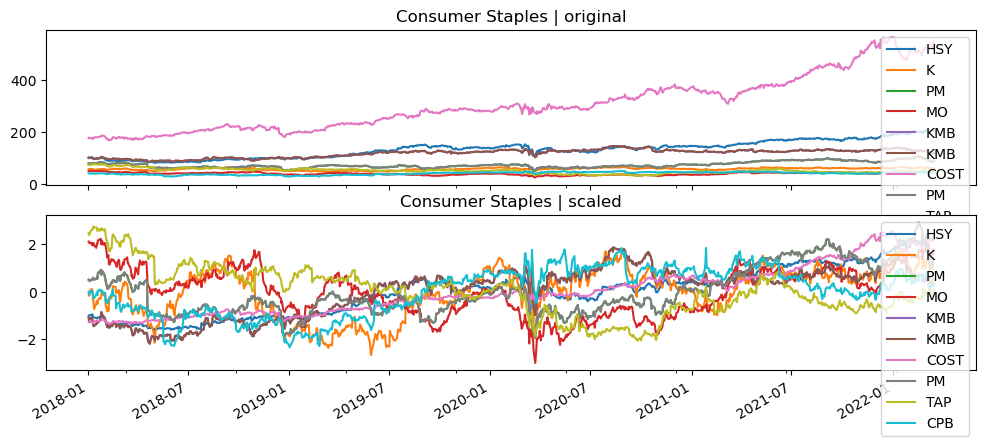

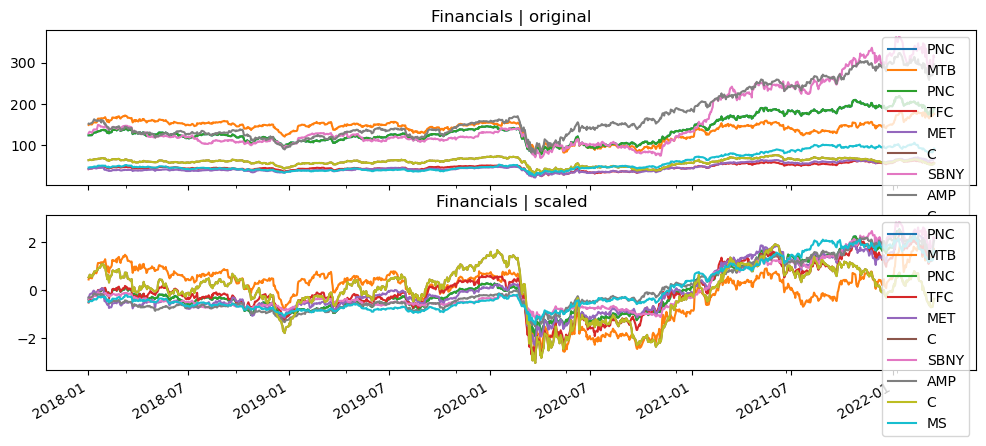

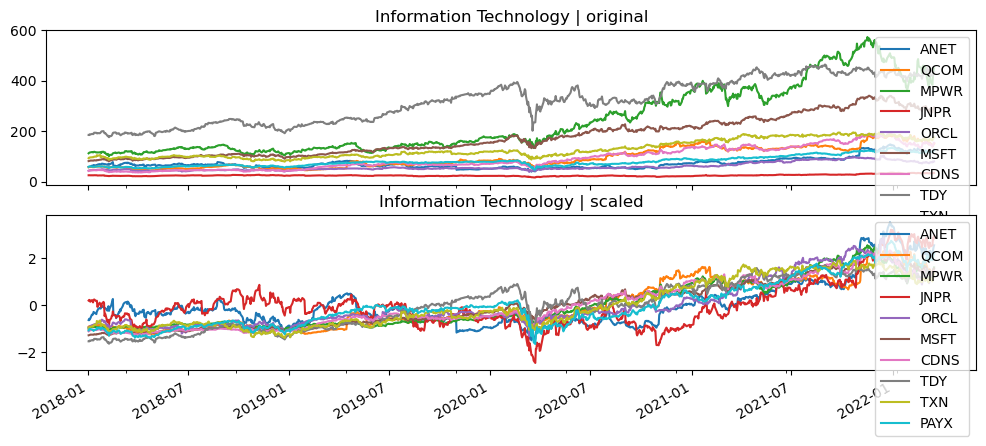

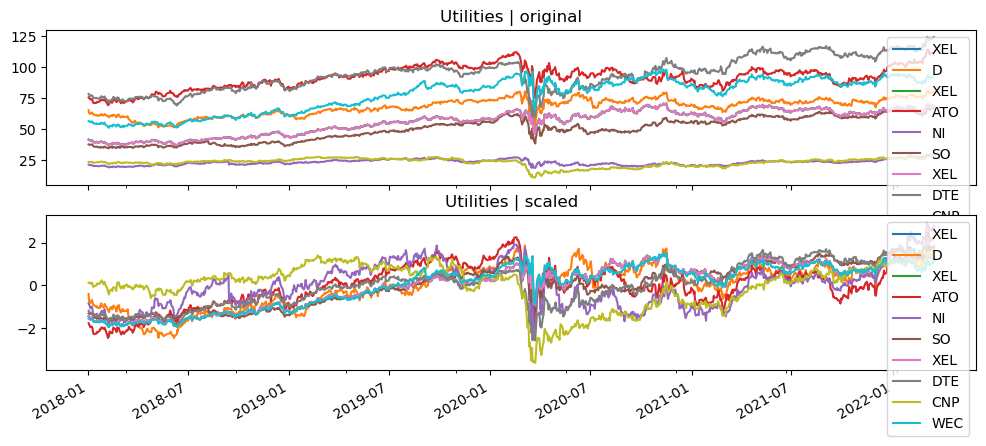

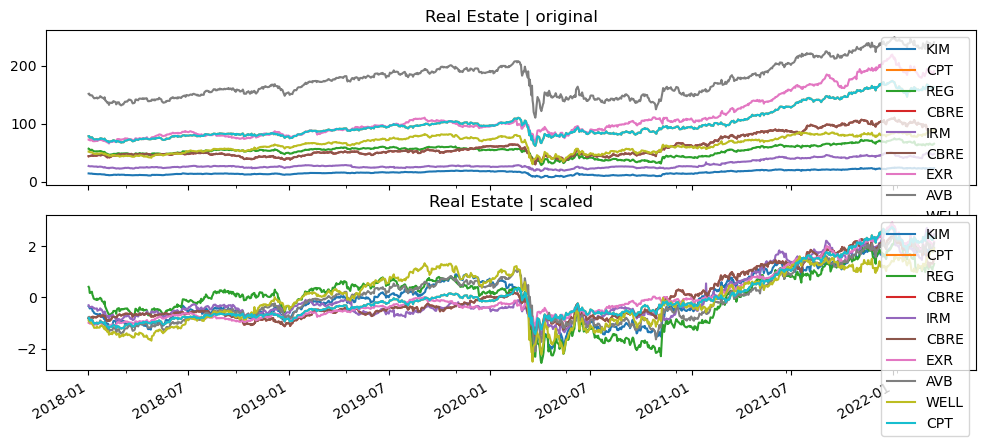

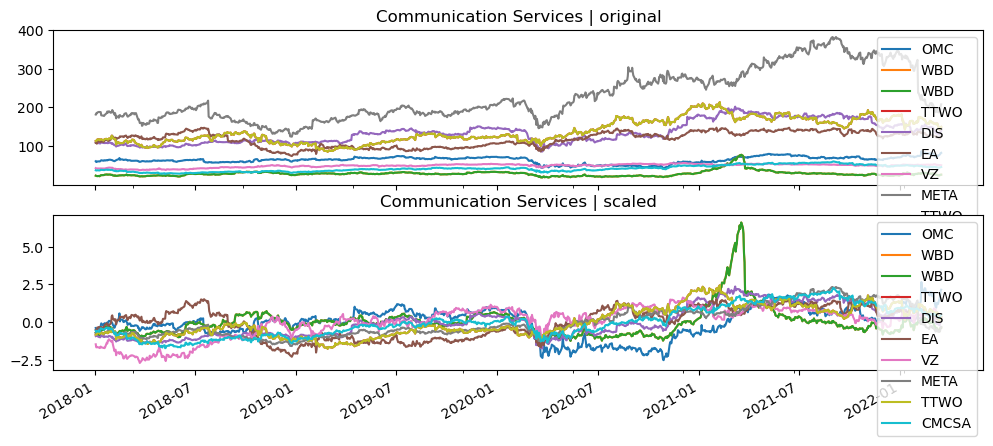

In [26]:
for sector in set(y_train):
    stocks_with_sector = y_train==sector
    df_subset = close_prices.loc[:,stocks_with_sector]
    sector_cols = df_subset.columns
    scaled_subset = pd.DataFrame(X_train[stocks_with_sector,:,0].T,\
                            columns = sector_cols)
    scaled_subset.index = df_subset.index
    random_columns = np.random.choice(sector_cols,size = min(10,len(scaled_subset)))
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    df_subset[random_columns].plot(ax=axes[0], title =f"{sector} | original")
    scaled_subset[random_columns].plot(ax=axes[1], title =f"{sector} | scaled")

### Time series clustering

In [27]:
### dummy data
from tslearn.datasets import CachedDatasets
X_train1, y_train1, X_test1, y_test1 = CachedDatasets().load_dataset("Trace")
X_train1 = X_train1[y_train1 < 4]  # Keep first 3 classes
X_train1.shape, y_train1.shape

((69, 275, 1), (100,))

In [28]:
X_train1.shape

(69, 275, 1)

In [29]:
X_train.shape

(479, 1060, 1)

In [30]:
def ad_clustering(X_train,y_train,k, seed = SEED):
    model = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,tol=1e-4,
                          random_state=seed,n_jobs=-1)
    y_pred = model.fit_predict(X_train)
    ami1 = ami(labels_true = y_train, labels_pred = y_pred)
    return (model,y_pred,ami1)

In [31]:
X_train[:10,1000:,].shape

(10, 60, 1)

In [32]:
result_dict={}
for k in tqdm(range(5,20)):
    result_dict[k] = ad_clustering(X_train[:10,1000:,],y_train[:10],k)
    print (f"For k = {k}, ami = {ami:.5%}")

  0%|          | 0/15 [00:00<?, ?it/s]

TypeError: unsupported format string passed to function.__format__